In [1]:
import ctypes
import time
import os
from multiprocessing import Process, Queue
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_CCnt = ctypes.CDLL('./CCnt.so')

## Testing signed vs unsigned 32-bit integers

In [ ]:
signed = ctypes.c_uint32(_CCnt.getCC()).value
unsigned = signed
if unsigned < 0:
    unsigned += 2**32
print(signed)
print(unsigned)

In [2]:
t1 = 4294967295
t2 = 1
t3 = t2-t1
t3 += 2**32
print(t3)

2


In [3]:
def recur_fibo(n):
   if n <= 1:
       return n
   else:
       return(recur_fibo(n-1) + recur_fibo(n-2))


## Timed Fibonacci Function

In [4]:
def timed_fib(n, CPU = -1):
    if CPU >= 0:
        os.system("taskset -pc {} {}".format(CPU,p_fib.pid))
    
    #reset/initialize counter
    if n > 30:
        _CCnt.init(1,1) #use divider for larger numbers to avoid overflow
    else:
        _CCnt.init(1,0) #don't use divider for smaller numbers for greater precision
    
    t_before = time.time()
    cc_before = ctypes.c_uint32(_CCnt.getCC()).value

    recur_fibo(n)
        
    cc_after = ctypes.c_uint32(_CCnt.getCC()).value
    t_after = time.time()
        
    elapsed_time = t_after-t_before
    num_cycles = cc_after-cc_before
    
    #account for possibility of overflow
    if num_cycles < 0:
        num_cycles += 2**32
    
    #print('Cycle count before: {}'.format(cc_before))
    #print('Cycle count after: {}'.format(cc_after))
    #print('Number of Cycles: {}'.format(num_cycles))
    #print('Elapsed Time: {} sec'.format(elapsed_time))
    
    if n > 30:
        est_time = 64*num_cycles/650000000
    else:
        est_time = num_cycles/650000000
        
    #print('Calculated time based on CPU Frequency: {} sec'.format(est_time))
    return (elapsed_time, num_cycles, est_time)

## Functions for Gathering and Analyzing Data

In [5]:
def collect_raw_data(n, TRIALS):
    dim = np.zeros((n,TRIALS))
    dim1 = np.ones((n,TRIALS))
    dim2 = 10*np.ones((n,TRIALS))
    cols = []; rows = []
    for i in range(0,TRIALS): cols.append("Run{}".format(i))
    for i in range(1,n+1): rows.append("n={}".format(i))
    raw_time_data = pd.DataFrame(dim,rows,cols)
    raw_clock_data = pd.DataFrame(dim1,rows,cols)
    raw_clock_time_data = pd.DataFrame(dim2,rows,cols)
    tt = time.time()
    for r_index, row in enumerate(rows):
        print('n={} took {} s, Now running for n={}'.format(r_index, round(tt,2), r_index+1))
        tt = time.time()
        for col in cols:
            (t1,c,t2) = timed_fib(r_index + 1)
            raw_time_data[col][row] = t1
            raw_clock_data[col][row] = c
            raw_clock_time_data[col][row] = t2
        tt = time.time()-tt
    print('Data Collected!')
    return raw_time_data, raw_clock_data, raw_clock_time_data

def analyze_data(rtd, rcd, rctd):
    time_data = rtd.transpose().describe().transpose().round(5)
    clock_data = rcd.transpose().describe().transpose().round(0)
    clock_time_data = rctd.transpose().describe().transpose().round(5)
    return time_data, clock_data, clock_time_data

def process(n,TRIALS,CPU,data):
    os.system("taskset -p -c {} {}".format(CPU,p_fib.pid))
    (rtd, rcd, rctd) = collect_raw_data(n, TRIALS)
    (td, cd, ctd) = analyze_data(rtd, rcd, rctd)
    data.put([rtd,rcd,rctd,td,cd,ctd])

## Run recur_fibo on a specific CPU:

In [6]:
n = 30
CPU = 1

#NOTE: This must be named p_fib in order to set the CPU affinity correctly
p_fib = Process(target=timed_fib, args=(CPU,n))
p_fib.start()
p_fib.join()

## 3.2 Gather and Analyze Data Across Multiple Values of n

In [7]:
n_max = 30
n_trials = 10
CPU = 1
data = Queue()

RAW_TIME_DATA, TIME_DATA = 0, 3
RAW_CLOCK_DATA, CLOCK_DATA = 1, 4
RAW_CLOCK_TIME_DATA, CLOCK_TIME_DATA = 2, 5

#NOTE: This must be named p_fib in order to set the CPU affinity correctly
p_fib = Process(target=process, args=(n_max,n_trials,CPU,data))
p_fib.start()
p_fib.join()
data = data.get()

n=0 took 1637429825.67 s, Now running for n=1
n=1 took 0.08 s, Now running for n=2
n=2 took 0.03 s, Now running for n=3
n=3 took 0.03 s, Now running for n=4
n=4 took 0.03 s, Now running for n=5
n=5 took 0.03 s, Now running for n=6
n=6 took 0.03 s, Now running for n=7
n=7 took 0.03 s, Now running for n=8
n=8 took 0.03 s, Now running for n=9
n=9 took 0.03 s, Now running for n=10
n=10 took 0.03 s, Now running for n=11
n=11 took 0.03 s, Now running for n=12
n=12 took 0.03 s, Now running for n=13
n=13 took 0.04 s, Now running for n=14
n=14 took 0.04 s, Now running for n=15
n=15 took 0.05 s, Now running for n=16
n=16 took 0.07 s, Now running for n=17
n=17 took 0.1 s, Now running for n=18
n=18 took 0.14 s, Now running for n=19
n=19 took 0.21 s, Now running for n=20
n=20 took 0.32 s, Now running for n=21
n=21 took 0.51 s, Now running for n=22
n=22 took 0.8 s, Now running for n=23
n=23 took 1.29 s, Now running for n=24
n=24 took 2.12 s, Now running for n=25
n=25 took 3.33 s, Now running for n=2

## Plots

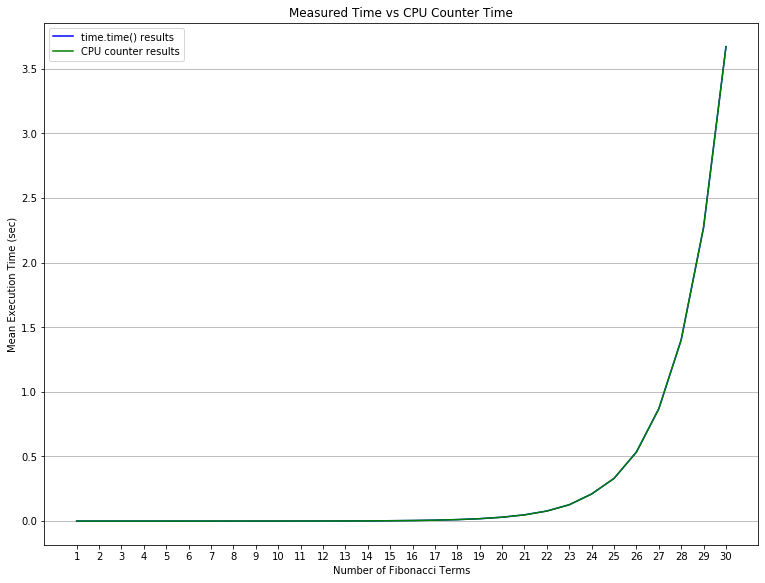

In [9]:
plt.figure(1, [12.8,9.6])
plt.plot(data[TIME_DATA]['mean'],'-b',label = 'time.time() results')
plt.plot(data[CLOCK_TIME_DATA]['mean'], '-g', label = 'CPU counter results')
plt.title('Measured Time vs CPU Counter Time')
plt.xlabel('Number of Fibonacci Terms')
plt.ylabel('Mean Execution Time (sec)')
plt.xticks(np.arange(0,n_max),np.arange(1,n_max+1))
plt.legend();
plt.grid(axis = 'y')

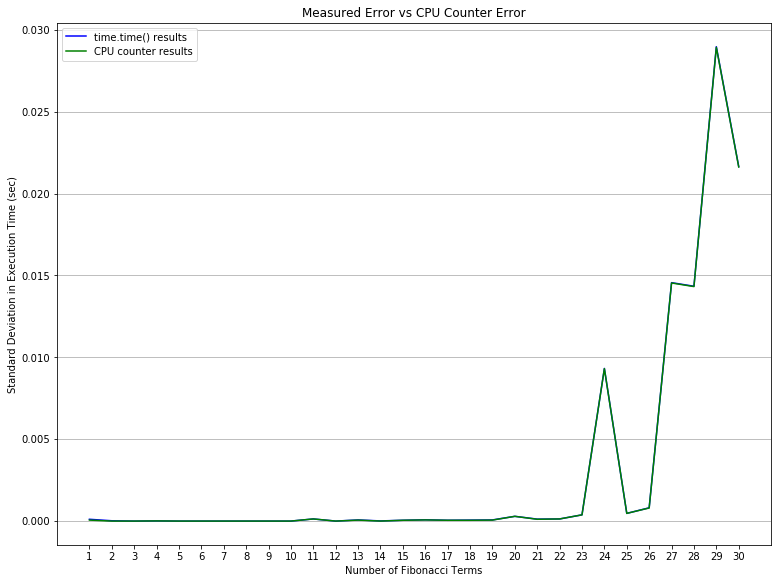

In [10]:
plt.figure(2, [12.8,9.6])
plt.plot(data[TIME_DATA]['std'],'-b',label = 'time.time() results')
plt.plot(data[CLOCK_TIME_DATA]['std'], '-g', label = 'CPU counter results')
plt.title('Measured Error vs CPU Counter Error')
plt.xlabel('Number of Fibonacci Terms')
plt.ylabel('Standard Deviation in Execution Time (sec)')
plt.xticks(np.arange(0,n_max),np.arange(1,n_max+1))
plt.legend();
plt.grid(axis = 'y')

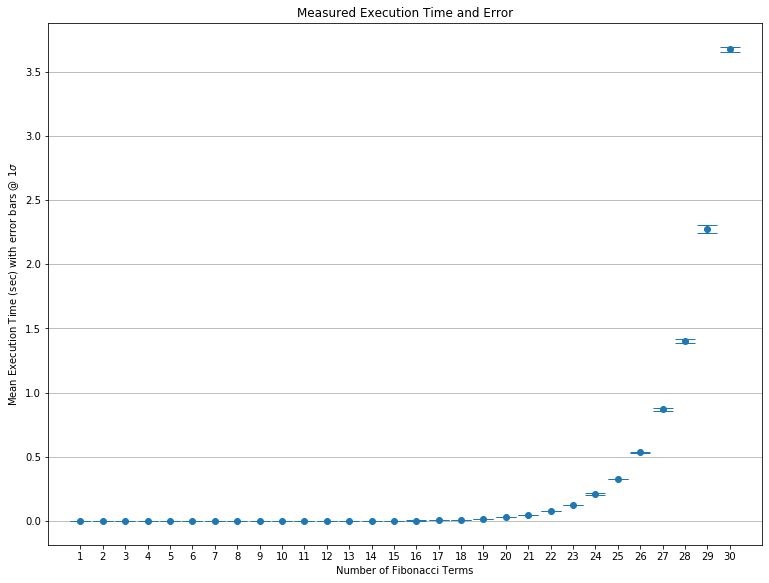

In [11]:
time_mean = data[TIME_DATA]['mean'].to_numpy()
time_std = data[TIME_DATA]['std'].to_numpy()
plt.figure(3, [12.8,9.6])
plt.errorbar(np.arange(1,n_max+1),time_mean,time_std,fmt='o', linewidth=2, capsize=10);
plt.xticks(np.arange(1,n_max+1),np.arange(1,n_max+1));
plt.title('Measured Execution Time and Error')
plt.xlabel('Number of Fibonacci Terms')
plt.ylabel('Mean Execution Time (sec) with error bars @ 1'r'$\sigma$');
plt.grid(axis = 'y')

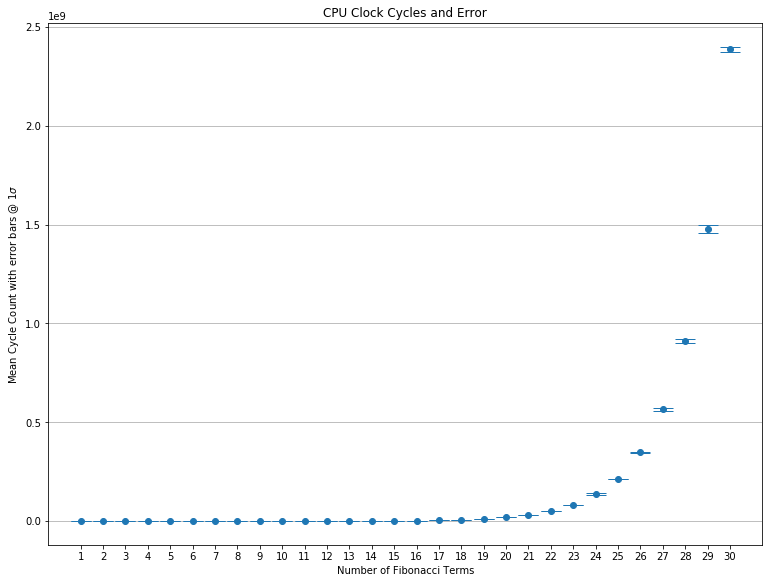

In [12]:
cycle_mean = data[CLOCK_DATA]['mean'].to_numpy()
cycle_std = data[CLOCK_DATA]['std'].to_numpy()
plt.figure(4, [12.8,9.6])
plt.errorbar(np.arange(1,n_max+1),cycle_mean,cycle_std,fmt='o', linewidth=2, capsize=10);
plt.xticks(np.arange(1,n_max+1),np.arange(1,n_max+1));
plt.title('CPU Clock Cycles and Error')
plt.xlabel('Number of Fibonacci Terms')
plt.ylabel('Mean Cycle Count with error bars @ 1'r'$\sigma$');
plt.grid(axis = 'y')